# Apprentissage sur les données `litcovid`
Dans ce notebook, nous explorons les données contenues dans l'archive `litcovid`, et comparons plusieurs modèles pour la prédiction des catégories : 
* Méthodes traditionnelles : TF-IDF + modèles scikit-learn
* Réseaux simples
* BioBert

In [ ]:
import json
import os, sys, ast, re
from tqdm import tqdm
import requests
import time

import numpy as np
import pandas as pd
from collections import Counter

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
seed = 42

## Data Exploration

In [ ]:
litcovid = requests.get('https://pageperso.lis-lab.fr/benoit.favre/covid19-data/20201206/litcovid.json').json()

In [ ]:
litcovid[0]

{'_id': '33273934',
 'abstract': 'The COVID-19 outbreak is public health emergency, spreads easily from human to human, and may cause acute severe respiratory syndrome. The anesthesia teams who perform this procedure are at risk aerosolization and need special consideration and safety measures. Cardiac anesthesiologist follows two aims, recognition of COVID-19 patients that need surgery and decreasing the risk of perioperative viral transmission to coworkers. An isolated operating room (negative pressure operating room for COVID-19) should be available. It is important to regulate workflow and practices, anesthesia management, healthcare, and staff. Cardiac anesthesiologist and health-care workers must be use guidelines to treat patients with COVID-19.',
 'authors': ['Ziyaeifard, Mohsen', 'Ziyaeifard, Parisa'],
 'date': '2020-12-05T12:00:00Z',
 'journal': 'J Res Med Sci',
 'pmcid': 'PMC7698443',
 'pmid': 33273934,
 'text_hl': None,
 'title': 'Cardiac anesthesia and COVID-19 outbreak: W

In [ ]:
len(litcovid)

77522

In [ ]:
df = pd.DataFrame(litcovid)
df.head()

,pmid,pmcid,title,journal,authors,date,_id,topics,text_hl,abstract,countries
0,33273934,PMC7698443,Cardiac anesthesia and COVID-19 outbreak: What...,J Res Med Sci,"[Ziyaeifard, Mohsen, Ziyaeifard, Parisa]",2020-12-05T12:00:00Z,33273934,[Prevention],None,The COVID-19 outbreak is public health emergen...,NaN
1,33271925,NaN,Establishment of Murine Hybridoma Cells Produc...,Int J Mol Sci,"[Antipova, Nadezhda V, Larionova, Tatyana D, S...",2020-12-05T12:00:00Z,33271925,"[Diagnosis, Mechanism, Treatment]",None,In 2020 the world faced the pandemic of COVID-...,NaN
2,33275269,NaN,Procalcitonin is a predictor of disseminated i...,Eur Rev Med Pharmacol Sci,"[Asoglu, R, Tibilli, H, Afsin, A, Turkmen, S, ...",2020-12-05T12:00:00Z,33275269,"[Diagnosis, Treatment]",None,The coagulopathies that present with COVID-19 ...,NaN
3,33275275,NaN,Application of machine intelligence technology...,Eur Rev Med Pharmacol Sci,"[Alsharif, M H, Alsharif, Y H, Albreem, M A, J...",2020-12-05T12:00:00Z,33275275,[Treatment],None,Researchers have found many similarities betwe...,NaN
4,33272571,NaN,Structural stability of SARS-CoV-2 virus like ...,Biochem Biophys Res Commun,"[Sharma, A, Preece, B, Swann, H, Fan, X, McKen...",2020-12-05T12:00:00Z,33272571,[Mechanism],None,SARS-CoV-2 is a novel coronavirus which has ca...,NaN


In [ ]:
df.columns

Index(['pmid', 'pmcid', 'title', 'journal', 'authors', 'date', '_id', 'topics',
       'text_hl', 'abstract', 'countries'],
      dtype='object')

Les colonnes qui nous intéressent sont le titre (`title`), l'`abstract` et la catégorie (`topic`).

In [ ]:
df.isna().sum(axis=0) / df.shape[0]

pmid         0.000000
pmcid        0.312737
title        0.000013
journal      0.000013
authors      0.010784
date         0.000000
_id          0.000000
topics       0.294020
text_hl      1.000000
abstract     0.000800
countries    0.680633
dtype: float64

On s'intéresse ici à la prédiction de catégories, on enlève donc les données sans label.



In [ ]:
df = df[~df.topics.isna()]
df.shape

(54729, 11)

Vérification des catégories:

In [ ]:
Counter([y for x in df.topics.tolist() for y in x])

Counter({'Case Report': 4567,
         'Diagnosis': 12276,
         'Epidemic Forecasting': 1047,
         'General Info': 1743,
         'Mechanism': 8408,
         'NONE': 2,
         'Prevention': 24696,
         'Transmission': 2087,
         'Treatment': 17449})

In [ ]:
df[df.topics.apply(lambda x: 'NONE' in x)]

,pmid,pmcid,title,journal,authors,date,_id,topics,text_hl,abstract,countries
1256,33251082,PMC7682771,Intelligent computing with Levenberg-Marquardt...,Eur Phys J Plus,"[Cheema, Tahir Nawaz, Raja, Muhammad Asif Zaho...",2020-12-01T12:00:00Z,33251082,"[NONE, Epidemic Forecasting]",None,The aim of this work is to design an intellige...,"[Pakistan, China]"
30213,32847378,PMC7453156,To tele- or not to telehealth? Ongoing COVID-1...,Australas Psychiatry,"[Looi, Jeffrey Cl, Pring, William]",2020-08-28T12:00:00Z,32847378,"[NONE, Prevention]",None,Following a very rapid and significant uptake ...,[Australia]


On remarque que deux items contiennent le label `NONE`, qui n'était pas attendu ; ces deux items sont également mis de côté.

In [ ]:
df = df[~df.topics.apply(lambda x: 'NONE' in x)]
df.shape

(54727, 11)

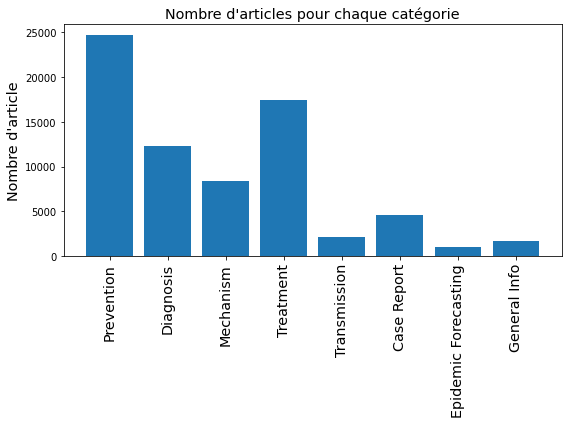

In [ ]:
fig = plt.figure(figsize=(8,6))
c = Counter([y for x in df.topics.tolist() for y in x])
plt.bar(np.arange(8), c.values())
plt.title('Nombre d\'articles pour chaque catégorie',size='x-large')
plt.ylabel('Nombre d\'article',size='x-large')
plt.xticks(np.arange(8), c.keys(), rotation='vertical',size='x-large')
plt.tight_layout()
plt.show()

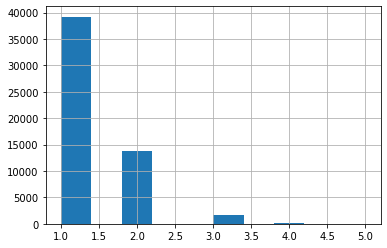

In [ ]:
df.topics.apply(len).hist()

In [ ]:
df.topics.apply(len).value_counts() / df.topics.shape[0]

1    0.716374
2    0.250955
3    0.028889
4    0.003289
5    0.000493
Name: topics, dtype: float64

La majorité des items ont 1 label, certains en ont 2, une minorité 3 ou 4 (sur 8).

In [ ]:
df.isna().sum(axis=0) / df.shape[0]

pmid         0.000000
pmcid        0.279898
title        0.000000
journal      0.000000
authors      0.006615
date         0.000000
_id          0.000000
topics       0.000000
text_hl      1.000000
abstract     0.000767
countries    0.658962
dtype: float64

Quelle est la longueur moyenne des abstracts ?

In [ ]:
abstracts = df[~df.abstract.isna()].abstract
abstracts.shape, abstracts[0]

((54685,),
 'The COVID-19 outbreak is public health emergency, spreads easily from human to human, and may cause acute severe respiratory syndrome. The anesthesia teams who perform this procedure are at risk aerosolization and need special consideration and safety measures. Cardiac anesthesiologist follows two aims, recognition of COVID-19 patients that need surgery and decreasing the risk of perioperative viral transmission to coworkers. An isolated operating room (negative pressure operating room for COVID-19) should be available. It is important to regulate workflow and practices, anesthesia management, healthcare, and staff. Cardiac anesthesiologist and health-care workers must be use guidelines to treat patients with COVID-19.')

In [ ]:
# Nombre de phrases moyen
print(abstracts.apply(lambda x: x.split('. ')).apply(len).mean())
# Nombre de mots moyen
print(abstracts.apply(lambda x: x.split(' ')).apply(len).mean())
# Nombre de token moyen
print(abstracts.apply(len).mean())

6.708329523635366
144.12886531955746
989.8019018012252


Concaténation des titres / abstracts en 1 seul feature :

In [ ]:
df['abstract'] = df.abstract.fillna('')

In [ ]:
df['x_concat'] = (df['title'] + ' ' + df.abstract).apply(lambda x: x.strip())
X = df.x_concat.tolist()
y = df.topics

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

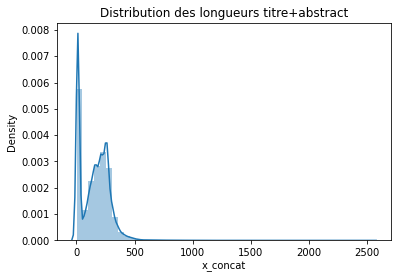

In [ ]:
sns.distplot(df['x_concat'].apply(lambda x: x.split(' ')).apply(len))
plt.title('Distribution des longueurs titre+abstract')
plt.plot()

D'autres features pourraient-ils être utilisés, en plus des titres / abstracts ? Le titre du journal par exemple n'est jamais manquant :

In [ ]:
print(len(df.journal.unique().tolist()))
df.journal.value_counts()

4739


BMJ                                 751
J Med Virol                         709
Clin Infect Dis                     461
PLoS One                            455
Int J Environ Res Public Health     424
                                   ... 
Early Interv Psychiatry               1
Ecosyst Serv                          1
Mol Immunol                           1
Int J Prod Econ                       1
J Clin Tuberc Other Mycobact Dis      1
Name: journal, Length: 4739, dtype: int64

# Traditional Machine Learning Models

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

Pour travailler avec scikit-learn, on transforme les classes (rappel : on est dans un cadre multi-label).

In [ ]:
mb = MultiLabelBinarizer()
y_bin = mb.fit_transform(y)
classes = mb.classes_
classes

array(['Case Report', 'Diagnosis', 'Epidemic Forecasting', 'General Info',
       'Mechanism', 'Prevention', 'Transmission', 'Treatment'],
      dtype=object)

Création des sets train / test / validation :

In [ ]:
train_texts, test_texts, y_train, y_test, train_labels, test_labels = train_test_split(X, y, y_bin, test_size=0.25, random_state=seed)
train_texts, valid_texts, y_train, y_valid, train_labels, valid_labels = train_test_split(train_texts, y_train, train_labels, test_size=0.1, random_state=seed)

To compare with simpler but competitive tradi- tional baselines we use the default scikit-learn implementation of logistic regression and linear support vector machine (SVM) for multi-label classification which trains one clas- sifier per class using a one-vs-rest scheme. Both models use TF-IDF weighted bag-of-words as input.

In [ ]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
# needs unicode https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document
X_train = vectorizer.fit_transform([str(x) for x in train_texts]) 
X_valid = vectorizer.transform([str(x) for x in valid_texts])

In [ ]:
lr = OneVsRestClassifier(LogisticRegression())
lr.fit(X_train, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [ ]:
#svm = OneVsRestClassifier(SVC(decision_function_shape='ovr'))
#svm.fit(X_train, train_labels)

In [ ]:
y_pred = lr.predict(X_valid)

In [ ]:
print(classification_report(valid_labels, y_pred, target_names=mb.classes_))

                      precision    recall  f1-score   support

         Case Report       0.95      0.65      0.77       417
           Diagnosis       0.88      0.74      0.80       933
Epidemic Forecasting       0.88      0.40      0.55        70
        General Info       0.92      0.18      0.29       137
           Mechanism       0.91      0.75      0.82       652
          Prevention       0.90      0.90      0.90      1744
        Transmission       0.81      0.33      0.47       156
           Treatment       0.89      0.82      0.85      1313

           micro avg       0.90      0.77      0.83      5422
           macro avg       0.89      0.59      0.68      5422
        weighted avg       0.90      0.77      0.82      5422
         samples avg       0.82      0.80      0.79      5422



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


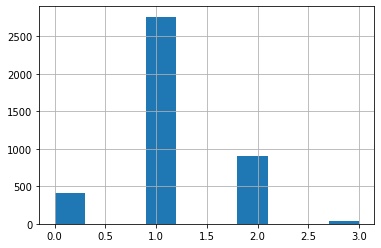

In [ ]:
pred_classes = pd.Series([classes[x] for x in y_pred.astype(bool)], name='prediction')
pred_classes.apply(len).hist()

On peut remarquer que le problème, en utilisant une classification multi-label, est que certains items se retrouvent _sans_ label.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix # only for sklearn classifiers

def generate_cm(tensor_true, tensor_predict, classes, normalize:str='index', return_df:bool=False):
    """Plot ConfusionMatrix, eventually return y_true/y_pred as pd.DataFrame
    
    Transforme les données multilabel en 1 ligne par label, et observe la matrice 
    de confusion comme si il n'y avait qu'un label par item.
    
    Moins précis que `sklearn.metrics.multilabel_confusion_matrix`, basée sur l'assomption que 
    la majorité des éléments n'ont au maximum qu'un seul label prédit faux.

    Step1: sélection des labels en commun
    Step2: appariement des labels restants
    """
    # pandas.core.series.Series, torch.Tensor, numpy.ndarray
    if isinstance(tensor_predict, torch.Tensor): # else np.ndarray
        tensor_predict = tensor_predict.numpy()
    pred_classes = pd.Series([classes[x] for x in tensor_predict.astype(bool)], name='prediction')
    if isinstance(tensor_true, torch.Tensor): # else pd.Series
        y_valid = pd.Series([classes[x] for x in tensor_true.numpy().astype(bool)], name='topics')
    else:
        y_valid = tensor_true
    
    df_all = pred_classes.explode().reset_index(drop=False).rename(columns={'index':'item'}).fillna('NONE')
    df_true = y_valid.reset_index(drop=True).explode().reset_index(drop=False).rename(columns={'index':'item'}).fillna('NONE')
    # Transform - 1: item_2 (commons)
    for df, col in zip([df_all, df_true], ['prediction', 'topics']):
        df.item = df.item.apply(lambda x: f'item_{x:04}')
        df['item_2'] = df.item + '_' + df[col]
    df_m1 = df_all.set_index('item_2')[['prediction']].join(df_true.set_index('item_2')[['topics']], how='inner')
    uniq_m1 = df_m1.index.tolist()
    # Transform - 2: item (appariement par ordre)
    df_all = df_all[~df_all.item_2.isin(uniq_m1)]
    df_true = df_true[~df_true.item_2.isin(uniq_m1)]
    for df, col in zip([df_all, df_true], ['prediction', 'topics']):
        df['successive'] = df.groupby('item').count()[col].apply(lambda x: list(range(x))).explode().tolist()
        df['item_3'] = df.item + '_' + df.successive.astype(str)
    df_m2 = df_all.set_index('item_3')[['prediction']].join(df_true.set_index('item_3')[['topics']], how='outer').fillna('NONE')
    # Merge
    df_merge = pd.concat([df_m1, df_m2])
    #df_merge = df_merge[~((df_merge.topics == 'NONE') & (df_merge.prediction == 'NONE'))]
    # plot
    cm = pd.crosstab(df_merge.topics, df_merge.prediction, normalize=normalize)
    fig, ax=plt.subplots(figsize=(8,8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm.to_numpy(), display_labels=cm.columns)
    disp.plot(cmap='viridis', ax=ax, xticks_rotation='vertical')
    
    if return_df:
        return df_merge

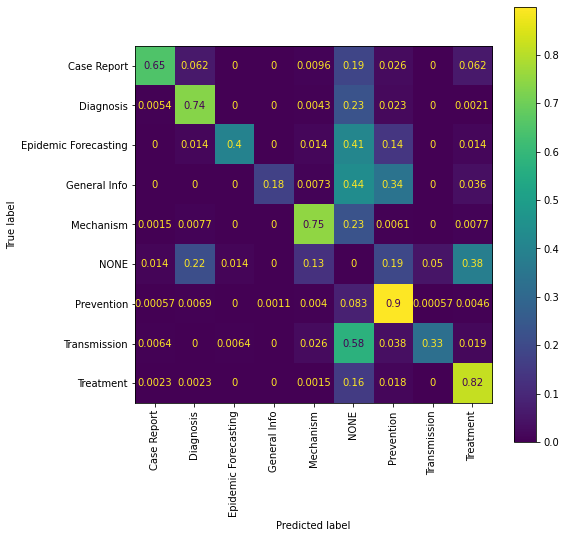

In [ ]:
df_test = generate_cm(y_valid, y_pred, classes, return_df=True)

On remarque déjà que la majorité des labels qui ne sont _pas_ prédits correspondent à des classes sous représentées. On remarque aussi que `Epidemic Forecasting` et `General Info` sont souvent confondus avec `Prevention`.

Il y aurait aussi plus souvent des labels qui sont prédits en trop / en moins plutôt que des confusions entre labels.

# Conventional Neural Models

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [ ]:
maxlen = 500 # from previous analysis, most texts have len < 500
batch_size = 256
hidden_size = 128
embed_size = 128
device = torch.device('cuda')

In [ ]:
!pip -q install transformers
from transformers import DistilBertTokenizer, BertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def bert_text_to_ids(sentence, tokenizer):
  return torch.tensor(tokenizer.encode(sentence, add_special_tokens=True))

     |████████████████████████████████| 1.5MB 9.0MB/s 
     |████████████████████████████████| 890kB 30.1MB/s 
     |████████████████████████████████| 2.9MB 42.2MB/s 


In [ ]:
import collections
label_vocab = collections.defaultdict(lambda: len(label_vocab))

def prepare_texts(texts:list, labels:list, 
          maxlen=530, 
          tokenizer=BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1'), 
          device=torch.device('cuda')):
  """Ajout de padding pour que tous les textes aient la même longueur et indexation des tokens grace au tokenizer
  
  Retourne les données au format tensor.
  """
  X = torch.LongTensor(len(texts), maxlen).fill_(tokenizer.pad_token_id)
  for i, text in enumerate(texts):
    indexed_tokens = bert_text_to_ids(text, tokenizer)
    length = min([maxlen, len(indexed_tokens)])
    X[i,:length] = indexed_tokens[:length]
  
  Y = torch.tensor(labels).long()
  return X.to(device), Y.to(device)

In [ ]:
X_train, Y_train = prepare_texts(train_texts, train_labels, maxlen=maxlen, tokenizer=tokenizer, device=device) 
X_valid, Y_valid = prepare_texts(valid_texts, valid_labels, maxlen=maxlen, tokenizer=tokenizer, device=device)
X_test, Y_test = prepare_texts(test_texts, test_labels, maxlen=maxlen, tokenizer=tokenizer, device=device)

print(X_train.shape)
print(X_train[:3])

In [ ]:
train_set = TensorDataset(X_train, Y_train)
valid_set = TensorDataset(X_valid, Y_valid)
test_set = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

Définition des modèles:

In [ ]:
class RNNClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.embed = nn.Embedding(tokenizer.vocab_size, embed_size, padding_idx=tokenizer.pad_token_id)
    self.rnn = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=True, batch_first=True)
    self.dropout = nn.Dropout(0.3)
    self.decision = nn.Linear(1 * 2 * hidden_size, len(classes))
    self.to(device)
  
  def forward(self, x):
    embed = self.embed(x)
    output, hidden = self.rnn(embed) 
    drop = self.dropout(hidden.transpose(0, 1).reshape(x.shape[0], -1))
    return torch.softmax(self.decision(drop),1) # ajout de softmax

rnn_model = RNNClassifier()
with torch.no_grad():
  print(rnn_model(X_train[:3]).shape)

torch.Size([3, 8])


In [ ]:
class RCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(tokenizer.vocab_size, embed_size, padding_idx=tokenizer.pad_token_id) # sortie (batch_size, sequence_size, embed_size)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=False, batch_first=True)
        # sortie RNN: (batch, seq_len, hidden_size * num_directions)
        # entrée CNN: (batch_size, embedding_size, sequence_length)
        self.conv = nn.Conv1d(embed_size, hidden_size, kernel_size=2) # (in, out, kernel_size)
        self.dropout = nn.Dropout(.3)
        self.decision = nn.Linear(hidden_size, len(classes))
        self.to(device)

    def forward(self, x):
        embed = self.embed(x)
        output, hidden = self.rnn(embed)
        conv = F.relu(self.conv(output.transpose(1,2)))
        pool = F.max_pool1d(conv, conv.size(2)) 
        drop = self.dropout(pool)
        return torch.softmax(self.decision(drop.view(x.size(0), -1)),1)

rcnn_model = RCNN()
with torch.no_grad():
  print(rcnn_model(X_train[:3]).shape)

torch.Size([3, 8])


In [ ]:
def CrossEntropyLossOneHot(y_score=None, y=None):
    """CrossEntropy pour la multi classification
    """
    log_y_score = torch.log(y_score)
    cost = -torch.sum(y * log_y_score)
    return cost

def perf(model, loader, seuil:float=2e-1):
    """Evaluation en multi-label, le seuil désigne le niveau a partir duquel on considère une classe comme 'prédite'
    """
    criterion = CrossEntropyLossOneHot
    model.eval()
    total_loss = num = num_comp = correct = 0
    total_pred = true_y = None # concaténation des batchs
    for x, y in loader:
        with torch.no_grad():
            y_scores = model(x)
            loss = criterion(y_scores, y)
            y_pred = multi_hot(y_scores, seuil)
            if total_pred == None: # concat
                total_pred = y_pred
                true_y = y
            else:
                total_pred = torch.cat((total_pred,y_pred), dim=0)
                true_y = torch.cat((true_y,y), dim=0)
            correct += torch.sum(y_pred == y).item()
            total_loss += loss.item()
            num_comp += len(y) * classes.shape[0]
            num += len(y)

    f_score = f1_score(true_y.cpu(), total_pred.cpu(), average='micro')
    accu_score = accuracy_score(true_y.cpu(), total_pred.cpu())
    return total_loss / num, correct / num_comp, accu_score, f_score

In [ ]:
def multi_hot(y_pred, seuil=2e-1, to_gpu:bool=True):
    """binarize prediction using threshold
    """
    res = torch.zeros(y_pred.shape[0], y_pred.shape[1])#.int()
    res[torch.arange(y_pred.shape[0]), torch.argmax(y_pred, dim=1)] = 1
    for i in range(y_pred.shape[0]):
        for j in range(y_pred.shape[1]):
            if y_pred[i,j] > seuil:
                res[i,j] = 1
    if to_gpu:
        return res.to(device)
    return res

In [ ]:
def fit_rnn(model, train_loader, epochs, lr=1e-3, seuil=2e-1): # comparaison des seuils voire Bert
    criterion = CrossEntropyLossOneHot
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history  = {
        'train_losses' : [],
        'val_losses' : [],
        'preci' : [],
        'all_good_preci' : [],
        'f_micro' : [],
    }

    for epoch in range(epochs):
        model.train()
        total_loss = num = 0
        for x, y in tqdm(train_loader):
            optimizer.zero_grad()
            y_scores = model(x)
            loss = criterion(y_scores, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num += len(y)

        valloss, preci, accu_score, f_mesure = perf(model, valid_loader, seuil)
        history['train_losses'].append(total_loss / num)
        history['val_losses'].append(valloss)
        history['preci'].append(preci)
        history['all_good_preci'].append(accu_score)
        history['f_micro'].append(f_mesure)

        print(f'\nepoch : {epoch}\t - train loss : {total_loss / num}\t - val loss : {valloss}\t - precision :{preci}\t - all good precision : {accu_score}\t - f-score micro : {f_mesure}')

    return history

In [ ]:
def print_history(hist:dict, losses:bool=True, preci:bool=True, all_good_preci:bool=True, f_micro:bool=True):
    """
    Génération des graphes d'entrainement avec les données extraites lors du fit (losses, etc). Possibilité de ne générer que certains des graphes.

    hist: dict
        résultat de la fonction fit
    """
    nb_epoch = len(hist['train_losses'])
    x = np.arange(0,nb_epoch)
    if losses:
      plt.plot(x,hist['train_losses'], label='train')
      plt.plot(x,hist['val_losses'], label='val')
      plt.xlabel('Epoch')
      plt.ylabel('Losses')
      plt.legend()
      plt.show()
    
    for (cond, name, label) in (zip([preci, all_good_preci, f_micro],
                          ['preci', 'all_good_preci', 'f_micro'],
                          ['Precision pour chaque label séparement', 'Precision pour s\'ensemble des labels', 'F-score micro'])):
        if cond:
            plt.plot(x,hist[name])
            plt.xlabel('Epoch')
            plt.ylabel(label)
            plt.legend()
            plt.show()

In [ ]:
rnn_history = fit_rnn(rnn_model, train_loader, 10)

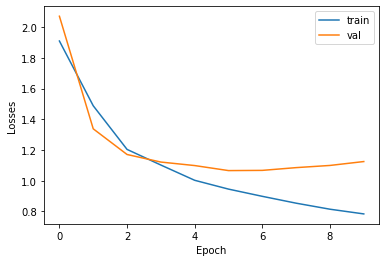

No handles with labels found to put in legend.


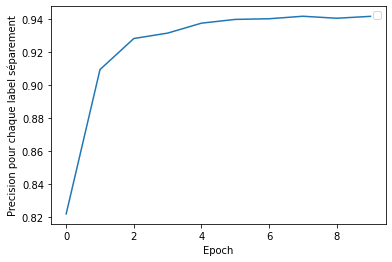

No handles with labels found to put in legend.


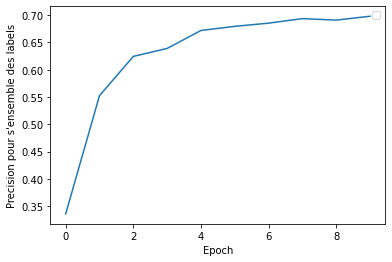

No handles with labels found to put in legend.


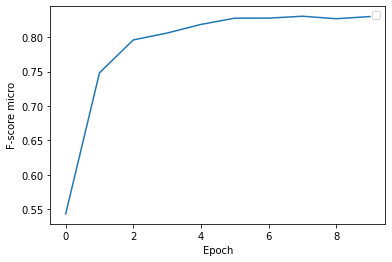

In [ ]:
print_history(rnn_history)

In [ ]:
rcnn_history = fit_rnn(rcnn_model, train_loader, 10)

In [ ]:
y_pred = multi_hot(rnn_model(X_valid), 2e-1)
print(classification_report(valid_labels, y_pred, target_names=mb.classes_))

# Pre-trained neural models

In [ ]:
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1')

print(tokenizer.tokenize('biomedical data are cool !'))
print(bert_text_to_ids('biomedical data are cool !', tokenizer))

['bio', '##medical', 'data', 'are', 'cool', '!']
tensor([  101, 25128, 20489,  2233,  1132,  4348,   106,   102])


In [ ]:
print('Train size:', len(train_labels))
print('Validation size:', len(valid_labels))
print('Test size:', len(test_labels))

Train size: 36940
Validation size: 4105
Test size: 13682


In [ ]:
maxlen = 200
batch_size = 32
hidden_size = 128
embed_size = 128
device = torch.device('cuda')

def create_loader(texts, labels, shuffle:bool=False, **kwargs):
    """
    kwargs: maxlen, tokenizer, device
    """
    X_train, Y_train = prepare_texts(texts, labels, **kwargs) 
    train_set = TensorDataset(X_train, Y_train)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=shuffle)
    return train_loader

In [ ]:
train_loader = create_loader(train_texts, train_labels, shuffle=True, maxlen=maxlen, tokenizer=tokenizer, device=device) 
valid_loader = create_loader(valid_texts, valid_labels, maxlen=maxlen, tokenizer=tokenizer, device=device) 
test_loader = create_loader(test_texts, test_labels, maxlen=maxlen, tokenizer=tokenizer, device=device) 

In [ ]:
from transformers import BertModel

class BioBertClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.bert = BertModel.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
    self.decision = nn.Linear(self.bert.config.hidden_size, classes.shape[0])
    self.to(device)

  def forward(self, x):
    output = self.bert(x, attention_mask = (x != tokenizer.pad_token_id).long())
    return torch.softmax(self.decision(torch.max(output[0], 1)[0]),1) # log => quantité positive

'''
bert_model = BioBertClassifier()
with torch.no_grad():
  print(bert_model(X_train[:3]))
print(Y_train[:3])
'''

'\nbert_model = BioBertClassifier()\nwith torch.no_grad():\n  print(bert_model(X_train[:3]))\nprint(Y_train[:3])\n'

In [ ]:
def fit(model, epochs, train_loader, 
          lrbio:float=1e-4, lrdeci:float=1e-02, 
          freezebio:bool=True, 
          seuil:float=2e-1):
    criterion = CrossEntropyLossOneHot

    #freeze biobert layers
    if freezebio :
      for parameter in model.parameters():
          parameter.requires_grad = False
      for name, param in model.named_parameters():
          if 'decision' in name:
              param.requires_grad = True
      optimizer = optim.Adam(model.parameters(), lr=lrdeci)

    #different lr pour bio et decision
    else :
      my_list = ['decision.weight', 'decision.bias']
      params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] in my_list, model.named_parameters()))))
      base_params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] not in my_list, model.named_parameters()))))
      optimizer = optim.Adam([{'params': base_params}, {'params': params, 'lr': lrdeci}], lr=lrbio)
      
    history  = {
        'train_losses' : [],
        'val_losses' : [],
        'preci' : [],
        'all_good_preci' : [],
        'f_micro' : [],
    }

    for epoch in range(epochs):
        model.train()
        total_loss = num = 0
        for x, y in tqdm(train_loader):
            optimizer.zero_grad()
            y_scores = model(x)
            loss = criterion(y_scores, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num += len(y)

        valloss, preci, accu_score, f_mesure = perf(model, valid_loader, seuil)
        history['train_losses'].append(total_loss / num)
        history['val_losses'].append(valloss)
        history['preci'].append(preci)
        history['all_good_preci'].append(accu_score)
        history['f_micro'].append(f_mesure)

        print(f'\nepoch : {epoch}\t - train loss : {total_loss / num}\t - val loss : {valloss}\t - precision :{preci}\t - all good precision : {accu_score}\t - f-score micro : {f_mesure}')

    return history

In [ ]:
bert_model = BioBertClassifier()
history = fit(bert_model, 3, train_loader, lrbio=3e-06, lrdeci=5e-03, freezebio=False)

  0%|          | 0/1155 [00:00<?, ?it/s]


epoch : 0	 - train loss : 1.2209514986584493	 - val loss : 1.0535787087555488	 - precision :0.9389464068209501	 - all good precision : 0.666747868453106	 - f-score micro : 0.822582072382975


  0%|          | 0/1155 [00:00<?, ?it/s]


epoch : 1	 - train loss : 1.0027089992599612	 - val loss : 1.0784526671619856	 - precision :0.9379110840438489	 - all good precision : 0.664068209500609	 - f-score micro : 0.8178651183564091


100%|██████████| 1155/1155 [24:38<00:00,  1.28s/it]



epoch : 2	 - train loss : 0.9588083476844709	 - val loss : 0.9901854868202349	 - precision :0.9485688185140073	 - all good precision : 0.7093788063337393	 - f-score micro : 0.8468027210884355


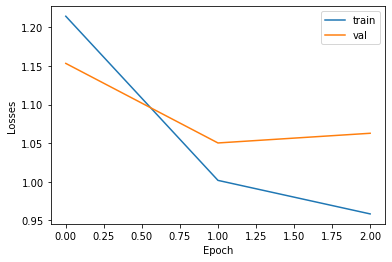

No handles with labels found to put in legend.


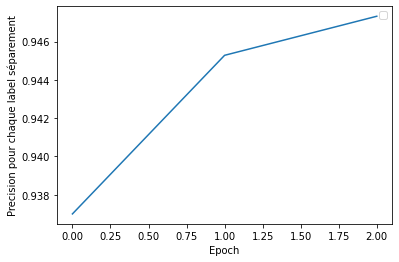

No handles with labels found to put in legend.


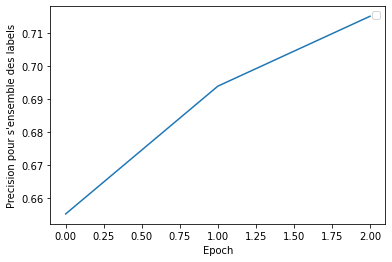

No handles with labels found to put in legend.


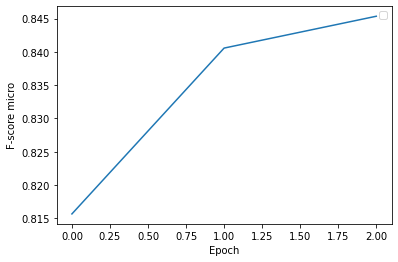

In [ ]:
print_history(history)

Saving/Loading

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#pour save le model
'''
PATH = '/content/gdrive/MyDrive/Colab Notebooks/projet_pstaln/biobertmodel'
torch.save(bert_model.state_dict(), PATH)
'''

In [ ]:
#load le model
'''
PATH = '/content/gdrive/MyDrive/Colab Notebooks/projet_pstaln/biobertmodel'
bert_model = BioBertClassifier()
bert_model.load_state_dict(torch.load(PATH))
bert_model.eval()
'''

In [ ]:
test_loss, test_preci, accu_score, f_score = perf(bert_model, test_loader, seuil=2e-1)
print('BioBERT -','test loss :', test_loss, '- precision :', test_preci, '- all good precision :', accu_score, '- f-score micro :', f_score)

Jetons un coup d'oeil aux résultats :

In [ ]:
def predict(model, loader):
    total_pred = true_y = None
    for x, y in loader:
        with torch.no_grad():
            y_scores = model(x)
            y_pred = multi_hot(y_scores, 2e-1)
            if total_pred == None: # concat
                total_pred = y_pred
                true_y = y
            else:
                total_pred = torch.cat((total_pred,y_pred), dim=0)
                true_y = torch.cat((true_y,y), dim=0)
    return true_y.cpu(), total_pred.cpu()

In [ ]:
y_valid, bert_predict = predict(bert_model, valid_loader)

In [ ]:
print(classification_report(y_valid, bert_predict, target_names=mb.classes_))

                      precision    recall  f1-score   support

         Case Report       0.90      0.89      0.89       417
           Diagnosis       0.75      0.91      0.82       933
Epidemic Forecasting       0.60      0.83      0.70        70
        General Info       0.53      0.80      0.64       137
           Mechanism       0.89      0.78      0.83       652
          Prevention       0.89      0.93      0.91      1744
        Transmission       0.64      0.54      0.58       156
           Treatment       0.88      0.81      0.84      1313

           micro avg       0.83      0.86      0.85      5422
           macro avg       0.76      0.81      0.78      5422
        weighted avg       0.84      0.86      0.85      5422
         samples avg       0.87      0.89      0.87      5422



1    0.665530
2    0.304019
3    0.030451
Name: prediction, dtype: float64


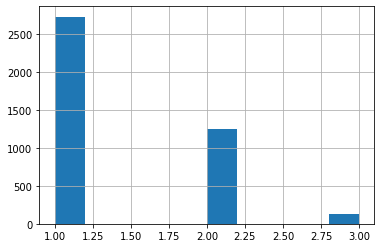

In [ ]:
pred_classes = pd.Series([classes[x] for x in bert_predict.numpy().astype(bool)], name='prediction')
print(pred_classes.apply(len).value_counts() / pred_classes.shape[0])
pred_classes.apply(len).hist()

Contrairement à LR, tous les articles ont au moins 1 label. Les proportions observées sont assez similaires aux proportions réelles.

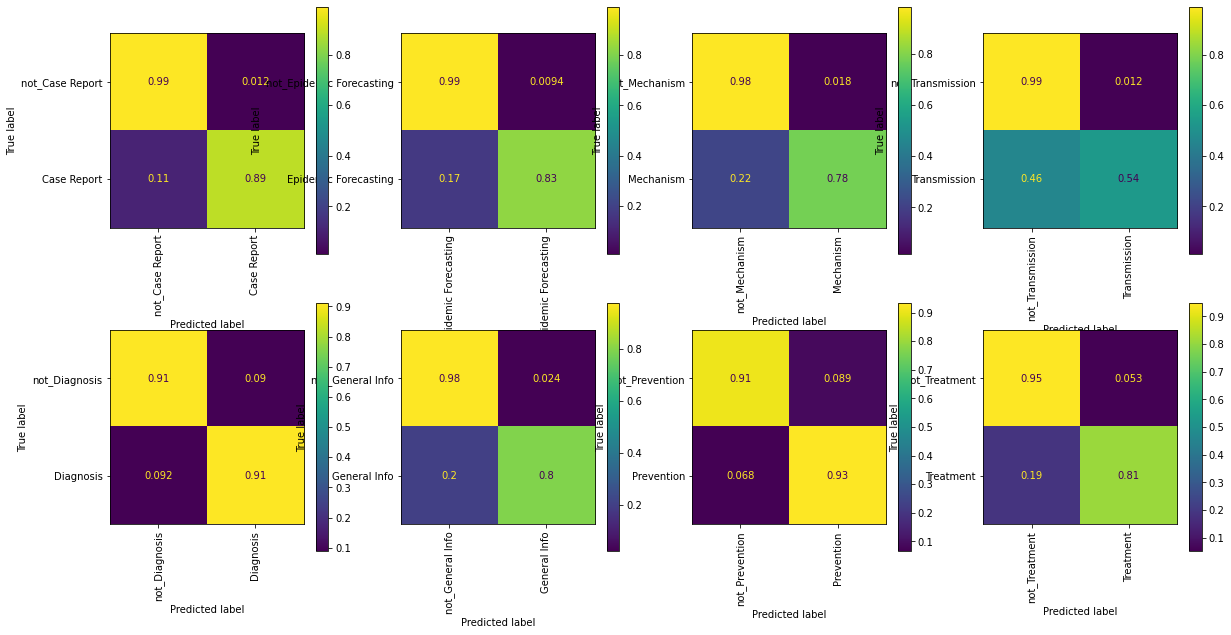

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
normalize = 'row' # row, column, False

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
for i, (cm, cl) in enumerate(zip(multilabel_confusion_matrix(y_valid.numpy(), bert_predict.numpy()), classes)):
    cm = (cm / cm.sum(axis=0)) if normalize == 'column' else ((cm.T / cm.sum(axis=1)).T if normalize == 'row' else cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'not_{cl}', cl])
    disp.plot(cmap='viridis', ax=ax[i%2][i//2], xticks_rotation='vertical')

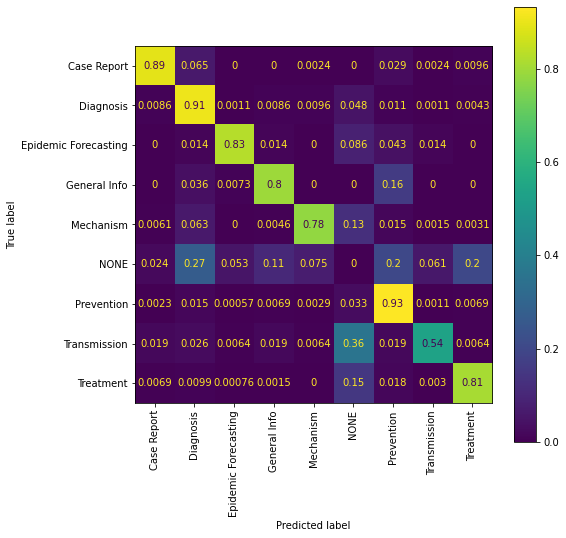

In [ ]:
generate_cm(y_valid, bert_predict, classes)

Comparé à LR, moins de labels dans la colonne "NONE" des prédictions (ce qui est normal, puisque BioBert prédit toujours au minimum 1 label pour chaque article)

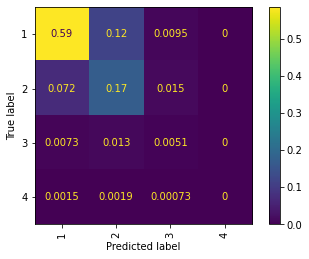

In [ ]:
cm_nb = confusion_matrix(pd.Series(y_valid.numpy().sum(axis=1), name='truth'),
           pd.Series(bert_predict.numpy().sum(axis=1), name='prediction').astype(int), normalize='all')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=[1,2,3,4])
disp.plot(cmap='viridis', xticks_rotation='vertical')

Comparaison des seuils de décision :

In [ ]:
verbose = False
seuils = np.arange(0.1,0.5,0.02)
losses = []
precis = []
all_good_preci = []
f_micro = []
for seuil in tqdm(seuils):
  if verbose :
    print(seuil)
  test_loss, test_prec, accu_score, f_score = perf(bert_model, test_loader, seuil=seuil)
  if verbose :
    print('BioBERT - Seuil :', seuil, '- test loss :', test_loss, '- precision :', test_preci, '- all good precision :', accu_score, '- f-score micro :', f_score)
  losses.append(test_loss)
  precis.append(test_preci)
  all_good_preci.append(accu_score)
  f_micro.append(f_score)

In [ ]:
print(f'best preci : {np.amax(precis)}- avec le seuil : {np.around(seuils[np.argmax(precis)], decimals=3)}')
print(f'best all_good_preci : {np.amax(all_good_preci)}- avec le seuil : {np.around(seuils[np.argmax(all_good_preci)], decimals=3)}')
print(f'best f-micro : {np.amax(f_micro)}- avec le seuil : {np.around(seuils[np.argmax(f_micro)], decimals=3)}')

In [ ]:
# Figure 1
plt.plot(seuils,precis)
plt.xlabel('Seuil')
plt.ylabel('Precision pour chaque label séparement')
plt.legend()
plt.show()

# Autres
for data, name in zip([all_good_preci, f_micro], ['Precision pour s\'ensemble des labels', 'F-score micro']):
    plt.figure()
    plt.plot(seuils, data)
    plt.xlabel(name)
    plt.ylabel()
    plt.legend()
    plt.show()

No handles with labels found to put in legend.


best preci : 0.9494750176618189 - avec le seuil : 0.24000000000000002
best all_good_preci : 0.6899071840970548 - avec le seuil : 0.24000000000000002
best f-micro : 0.8302129025355729 - avec le seuil : 0.18000000000000002


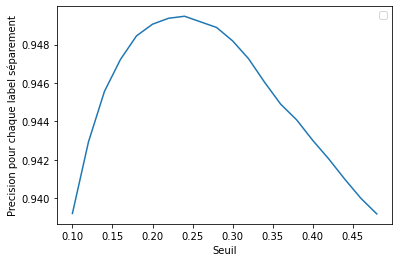

No handles with labels found to put in legend.


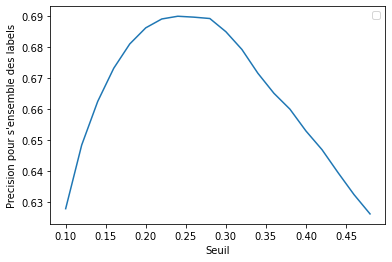

No handles with labels found to put in legend.


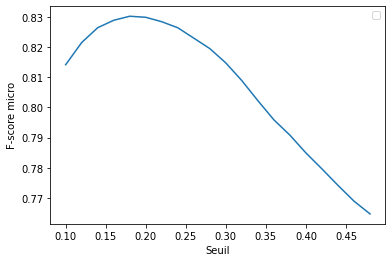

In [ ]:
print('best preci :', np.amax(precis), '- avec le seuil :', seuils[np.argmax(precis)])
print('best all_good_preci :', np.amax(all_good_preci), '- avec le seuil :', seuils[np.argmax(all_good_preci)])
print('best f-micro :', np.amax(f_micro), '- avec le seuil :', seuils[np.argmax(f_micro)])
plt.plot(seuils,precis)
plt.xlabel('Seuil')
plt.ylabel('Precision pour chaque label séparement')
plt.legend()
plt.show()
plt.plot(seuils,all_good_preci)
plt.xlabel('Seuil')
plt.ylabel('Precision pour s\'ensemble des labels')
plt.legend()
plt.show()
plt.plot(seuils,f_micro)
plt.xlabel('Seuil')
plt.ylabel('F-score micro')
plt.legend()
plt.show()

==> Choix de 0.2 pour le seuil

## Comparaison des modèles
Expériences : 
* Comparaison des performances selon la quantité de données pour l'entrainement
* Comparaison des performances selon que l'on ne conserve que le titre vs abstract vs titre + abstract

In [ ]:
train_texts_sets = {}
train_labels_sets = {}
test_texts_sets = {}
test_labels_sets = {}
percentages = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.8]

for percent in percentages:
    train_texts_sets[percent], test_texts_sets[percent], train_labels_sets[percent], test_labels_sets[percent] = train_test_split(X, 
                                                                                                                y_bin, test_size=1-percent, 
                                                                                                                random_state=seed)

In [ ]:
res = {
    x+'_'+y:{} for x in ['lr', 'rnn', 'bert'] for y in ['loss', 'preci', 'f_score', 'accu_score']
}

In [ ]:
# LR + TF-IDF
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')

for percent in percentages:
    print(f'training on {percent*100}percent data', end='')
    time_start = time.time()

    X_train = vectorizer.fit_transform([str(x) for x in train_texts_sets[percent]]) 
    X_valid = vectorizer.transform([str(x) for x in test_texts_sets[percent]])
    
    lr = OneVsRestClassifier(LogisticRegression())
    lr.fit(X_train, train_labels_sets[percent])
    y_pred = lr.predict(X_valid)

    res['lr_f_score'][percent] = f1_score(test_labels_sets[percent], y_pred, average='micro')
    res['lr_accu_score'][percent] = accuracy_score(test_labels_sets[percent], y_pred)
    print(f'\telapsed {np.around(time.time() - time_start,3)}s')


training on 1.0percent data	elapsed 5.512s
training on 2.0percent data	elapsed 6.044s
training on 5.0percent data	elapsed 6.558s
training on 10.0percent data	elapsed 7.374s
training on 20.0percent data	elapsed 9.534s
training on 50.0percent data	elapsed 18.42s
training on 80.0percent data	elapsed 27.878s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
train_loader_sets = {}
test_loader_sets = {}

### RNN param
maxlen = 500 
batch_size = 256
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

for percent in percentages:
    print(f"\n### percentage={percent*100}")
    train_loader_sets[percent] = create_loader(train_texts_sets[percent], train_labels_sets[percent], 
                                               shuffle=True, maxlen=maxlen, tokenizer=tokenizer, device=device) 
    test_loader_sets[percent] = create_loader(test_texts_sets[percent], test_labels_sets[percent], 
                                               maxlen=maxlen, tokenizer=tokenizer, device=device) 
    
    rnn_model = RNNClassifier()
    _ = fit_rnn(rnn_model, train_loader_sets[percent], 10)
    res['rnn_loss'][percent], res['rnn_preci'][percent], res['rnn_accu_score'][percent], res['rnn_f_score'][percent] = perf(rnn_model, 
                                                                                                test_loader_sets[percent], seuil=2e-1)

In [ ]:
for percent in percentages:
    print(f"\n### percentage={percent*100}")
    
    rcnn_model = RCNN()
    _ = fit_rnn(rcnn_model, train_loader_sets[percent], 10)
    res['rcnn_loss'][percent], res['rcnn_preci'][percent], res['rcnn_accu_score'][percent], res['rcnn_f_score'][percent] = perf(rcnn_model, 
                                                                                                test_loader_sets[percent], seuil=2e-1)

In [ ]:
# BERT
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
maxlen = 200
batch_size = 32

for percent in percentages:
    print(f"\n### percentage={percent*100}")
    train_loader = create_loader(train_texts_sets[percent], train_labels_sets[percent], 
                                               shuffle=True, maxlen=maxlen, tokenizer=tokenizer, device=device) 
    test_loader = create_loader(test_texts_sets[percent], test_labels_sets[percent], 
                                               maxlen=maxlen, tokenizer=tokenizer, device=device) 

    bert_model = BioBertClassifier()
    _ = fit(bert_model, 3, train_loader, lrbio=3e-06, lrdeci=5e-03, freezebio=False)
    res['bert_loss'][percent], res['bert_preci'][percent], res['bert_accu_score'][percent], res['bert_f_score'][percent] = perf(bert_model, 
                                                                                                                                test_loader, seuil=2e-1)


In [ ]:
{'bert_loss': {0.01: 1.6221428549830963, 0.02: 1.3608597152204185, 0.05: 1.0985369770954876, 0.1: 1.1103416335024867, 0.2: 1.1519631269365735, 0.5: 1.0175523033983402, 0.8: 1.0834197100607903
'bert_preci': {0.01: 0.8832710409745294, 0.02: 0.904704193313818, 0.05: 0.9384076090092516, 0.1: 0.9401050654755863, 0.2: 0.9320896715545202, 0.5: 0.9454529674024266, 0.8: 0.9462360679700347
'bert_f_score': {0.01: 0.6743139640422532, 0.02: 0.7347690710949663, 0.05: 0.8189975553577232, 0.1: 0.8222669046381853, 0.2: 0.8024287328061663, 0.5: 0.8392672059872662, 0.8: 0.84001631099633
'bert_accu_score': {0.01: 0.4492986341823551, 0.02: 0.5375794753230287, 0.05: 0.66103748725741, 0.1: 0.677677393158055, 0.2: 0.6381846420903567, 0.5: 0.6933562344686449, 0.8: 0.7066508313539193
'lr_accu_score': {0.01: 0.40662606127722406,  0.02: 0.4838439020752149,  0.05: 0.5741955338423957,  0.1: 0.6194701045579128,  0.2: 0.654058745603216,  0.5: 0.6913828387662623,  0.8: 0.707381691942262
'lr_f_score': {0.01: 0.5630093201386023,  0.02: 0.6496235714672588,  0.05: 0.7346035246085204,  0.1: 0.7726509773752491,  0.2: 0.7988745810887372,  0.5: 0.8260014306151646,  0.8: 0.8386431438989356
'rnn_accu_score': {0.01: 0.18844592100406055,  0.02: 0.2917606697369157,  0.05: 0.4628108711123079,  0.1: 0.4932697188102731,  0.2: 0.6063679137545109,  0.5: 0.6821371144569507,  0.8: 0.7138680796638042
'rnn_f_score': {0.01: 0.47832707090056237,  0.02: 0.5329463666652351,  0.05: 0.6482972723821918,  0.1: 0.7044476124606547,  0.2: 0.7738778070298508,  0.5: 0.8228885758368552,  0.8: 0.8409160305343512
'rnn_loss': {0.01: 2.167081516472868,  0.02: 2.033796920720889,  0.05: 1.7177877351124322,  0.1: 1.488854774147493,  0.2: 1.2858516557541964,  0.5: 1.1321481800344217,  0.8: 1.0799539804066554
'rnn_preci': {0.01: 0.803968253968254,  0.02: 0.8225928998937222,  0.05: 0.8752524475389971,  0.1: 0.8937214495990254,  0.2: 0.9217743593257504,  0.5: 0.9396972299371437,  0.8: 0.946453042207199
 }

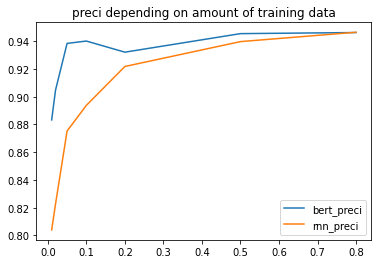

In [ ]:
# plotting
col_pattern = 'preci'
res_df = pd.DataFrame(res).dropna(axis='columns', how='all')
res_df[[col for col in res_df.columns if col_pattern in col]].plot(title=f'{col_pattern} depending on amount of training data')

Expérience 2 : performance titre vs abstract vs titre + abstract

In [ ]:
df_sub = df[df.abstract != ''] # only keeping those with abstract
X_1 = df_sub.title.tolist()
X_2 = df_sub.abstract.tolist()
X_3 = df_sub.concat.tolist()
y = df_sub.topics
y_bin = mb.fit_transform(y)

In [ ]:
train1_texts, test1_texts, train2_texts, test2_texts, train3_texts, test3_texts, train_labels, test_labels = train_test_split(
    X_1, X_2, X_3, y_bin, test_size=0.25)

In [ ]:
res2 = {'loss':{}, 'preci':{}, 'accu_score':{}, 'f_score':{} }

# title
# abstract full
# both - 100 char
# both - 200 char
# both - 550 char # impossible avec BioBert
for xtrain, xtest, name, maxlen in zip([train1_texts, train2_texts, train3_texts, train3_texts, train3_texts], 
            [test1_texts, test2_texts, test3_texts, test3_texts, test3_texts], 
            ['title', 'abstract', 'both - 100 char', 'both - 200 char', 'both - 550 char'], 
            [100, 200, 100, 200]):
    print(f'creating {name} dataloader')
    train_loader = create_loader(xtrain, train_labels, shuffle=True, maxlen=maxlen, tokenizer=tokenizer, device=device) 
    test_loader = create_loader(xtest, test_labels, maxlen=maxlen, tokenizer=tokenizer, device=device) 

    bert_model = BioBertClassifier()
    _ = fit(bert_model, 3, train_loader, lrbio=3e-06, lrdeci=5e-03, freezebio=False)
    res2['loss'][name], res2['preci'][name], res2['accu_score'][name], res2['f_score'][name] = perf(bert_model, test_loader, seuil=2e-1)

In [ ]:
# plotting
res = pd.DataFrame(res).dropna(axis='columns', how='all')
res[[col for col in res.columns if 'f_score' in col]].plot()